# 图像局部二值特征


## 一：局部二值模式（LBP）介绍 

局部二值模式(Local Binary Pattern)主要用来实现2D图像纹理分析。其基本思想是用每个像素跟它周围的像素相比较得到局部图像结构，假设中心像素值大于相邻像素值则则相邻像素点赋值为1，否则赋值为0，最终对每个像素点都会得到一个二进制八位的表示，比如11100111。假设3x3的窗口大小，这样对每个像素点来说组合得到的像素值的空间为[0~2^8]。这种结果我称为图像的局部二值模式或者简写为了LBP。 

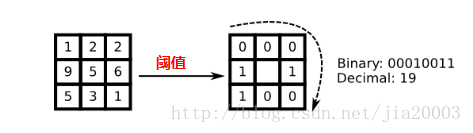

## 二：局部二值模式（LBP）扩展 
对于这种固定窗口大小方式的局部二值模式，很多人很快就发现它的弊端，不能很好的反映出图像结构，于是高人纷纷上阵把它改为窗口大小可变，而且把矩形结构改成圆形结构。而且还总结出来如下一系列的典型结构单元： 
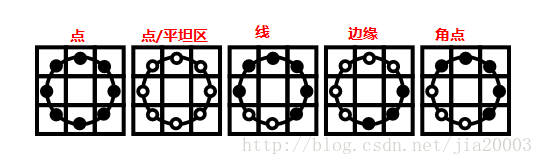

该操作是基于原来的局部二值模式的扩展，所以又被称为扩展的局部二值模式。但是一旦改为圆形的时候，寻找八个点坐标可能会产生小数坐标，这个时候就需要通过插值方式产生该像素点的像素值，最常见的插值方式基于双线性插值。这样就完成了任意尺度上的局部二值模式的采样。

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
import skimage.io
import imageio
import math

In [10]:
src = imageio.imread('../datas/f3.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

##  3x3模型

In [4]:
def lbp_3x3(src):
    img = src
    if len(src.shape) > 2:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    def thresholded(center, pixels):
        out = []
        for a in pixels:
            if a >= center:
                out.append(1)
            else:
                out.append(0)
        return out

    def get_pixel_else_0(l, idx, idy, default=0):
        try:
            return l[idx,idy]
        except IndexError:
            return default
    rows,cols = img.shape
    dst = np.zeros_like(img)
    for x in range(0, rows):
        for y in range(0, cols):
            center        = img[x,y]
            top_left      = get_pixel_else_0(img, x-1, y-1)
            top_up        = get_pixel_else_0(img, x, y-1)
            top_right     = get_pixel_else_0(img, x+1, y-1)
            right         = get_pixel_else_0(img, x+1, y )
            left          = get_pixel_else_0(img, x-1, y )
            bottom_left   = get_pixel_else_0(img, x-1, y+1)
            bottom_right  = get_pixel_else_0(img, x+1, y+1)
            bottom_down   = get_pixel_else_0(img, x,   y+1 )

            values = thresholded(center, [top_left, top_up, top_right, right, bottom_right,
                                          bottom_down, bottom_left, left])

            weights = [1, 2, 4, 8, 16, 32, 64, 128]
            res = 0
            for a in range(0, len(values)):
                res += weights[a] * values[a]
            
            dst[x,y] = res
    return dst

In [11]:
dst = lbp_3x3(src)

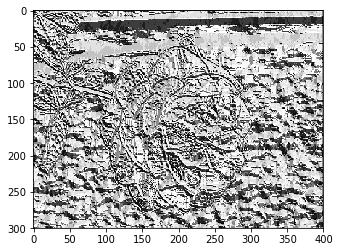

In [12]:
plt.imshow(dst,'gray')

## Circular

In [13]:
def lbp_circular(src):
    img = src
    if len(src.shape) > 2:
        img = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)
    def bilinear_interpolation(x, y, img):
        x1, y1 = int(r), int(c)
        x2, y2 = math.ceil(r), math.ceil(c)

        r1 = (x2 - x) / (x2 - x1) * get_pixel_else_0(img, x1, y1) + (x - x1) / (x2 - x1) * get_pixel_else_0(img, x2, y1)
        r2 = (x2 - x) / (x2 - x1) * get_pixel_else_0(img, x1, y2) + (x - x1) / (x2 - x1) * get_pixel_else_0(img, x2, y2)

        return (y2 - y) / (y2 - y1) * r1 + (y - y1) / (y2 - y1) * r2
    def thresholded(center, pixels):
        out = []
        for a in pixels:
            if a >= center:
                out.append(1)
            else:
                out.append(0)
        return out
    
    def get_pixel_else_0(l, idx, idy):
        if idx < int(len(l)) - 1 and idy < len(l[0]):
            return l[idx,idy]
        else:
            return 0
        
    dst = np.zeros_like(img)
    rows,cols = img.shape
    
    P = 8 # number of pixels
    R = 1 # radius 

    for x in range(0, len(img)):
        for y in range(0, len(img[0])):
            center        = img[x,y]
            pixels = []
            for point in range(0, P):
                r = x + R * math.cos(2 * math.pi * point / P)
                c = y - R * math.sin(2 * math.pi * point / P)
                if r < 0 or c < 0:
                    pixels.append(0)
                    continue            
                if int(r) == r:
                    if int(c) != c:
                        c1 = int(c)
                        c2 = math.ceil(c)
                        w1 = (c2 - c) / (c2 - c1)
                        w2 = (c - c1) / (c2 - c1)

                        pixels.append(int((w1 * get_pixel_else_0(img, int(r), int(c)) + \
                                       w2 * get_pixel_else_0(img, int(r), math.ceil(c))) / (w1 + w2)))
                    else:
                        pixels.append(get_pixel_else_0(img, int(r), int(c)))
                elif int(c) == c:
                    r1 = int(r)
                    r2 = math.ceil(r)
                    w1 = (r2 - r) / (r2 - r1)
                    w2 = (r - r1) / (r2 - r1)                
                    pixels.append((w1 * get_pixel_else_0(img, int(r), int(c)) + \
                                   w2 * get_pixel_else_0(img, math.ceil(r), int(c))) / (w1 + w2))
                else:
                    pixels.append(bilinear_interpolation(r, c, img))


            values = thresholded(center, pixels)
            res = 0
            for a in range(0, len(values)):
                res += values[a] * (2 ** a)

            dst[x,y] = res
            
    return dst

In [14]:
dst = lbp_circular(src)

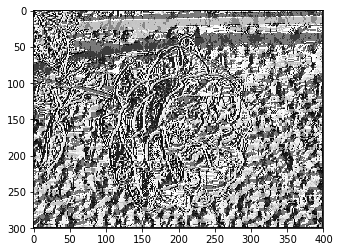

In [15]:
plt.imshow(dst,'gray')

## Uniform Circular LBP

In [16]:
def bilinear_interpolation(x, y, img):
    x1, y1 = int(x), int(y)
    x2, y2 = math.ceil(x), math.ceil(y)

    r1 = (x2 - x) / (x2 - x1) * get_pixel_else_0(img, x1, y1) + (x - x1) / (x2 - x1) * get_pixel_else_0(img, x2, y1)
    r2 = (x2 - x) / (x2 - x1) * get_pixel_else_0(img, x1, y2) + (x - x1) / (x2 - x1) * get_pixel_else_0(img, x2, y2)

    return (y2 - y) / (y2 - y1) * r1 + (y - y1) / (y2 - y1) * r2    

def thresholded(center, pixels):
    out = []
    for a in pixels:
        if a >= center:
            out.append(1)
        else:
            out.append(0)
    return out

def get_pixel_else_0(image, idx, idy):
    if idx < int(len(image)) - 1 and idy < len(image[0]):
        return image[idx,idy]
    else:
        return 0

def find_variations(pixel_values):
    prev = pixel_values[-1]
    t = 0
    for p in range(0, len(pixel_values)):
        cur = pixel_values[p]
        if cur != prev:
            t += 1
        prev = cur
    return t

def uniform_circular_lbp(img, P, R):
	variating_blocks = 0
	hist = {}
	for h in range(0, 256): # initialize the histogram
		hist[h] = 0 
	for x in range(0, len(img)):
		for y in range(0, len(img[0])):
			center = img[x,y]
			pixels = []
			for point in range(1, P + 1):
				r = x + R * math.cos(2 * math.pi * point / P)
				c = y - R * math.sin(2 * math.pi * point / P)
				if r < 0 or c < 0:
					pixels.append(0)
					continue            
				if int(r) == r:
					if int(c) != c:
						c1 = int(c)
						c2 = math.ceil(c)
						w1 = (c2 - c) / (c2 - c1)
						w2 = (c - c1) / (c2 - c1)
										
						pixels.append(int((w1 * get_pixel_else_0(img, int(r), int(c)) + \
									   w2 * get_pixel_else_0(img, int(r), math.ceil(c))) / (w1 + w2)))
					else:
						pixels.append(get_pixel_else_0(img, int(r), int(c)))
				elif int(c) == c:
					r1 = int(r)
					r2 = math.ceil(r)
					w1 = (r2 - r) / (r2 - r1)
					w2 = (r - r1) / (r2 - r1)                
					pixels.append((w1 * get_pixel_else_0(img, int(r), int(c)) + \
								   w2 * get_pixel_else_0(img, math.ceil(r), int(c))) / (w1 + w2))
				else:
					pixels.append(bilinear_interpolation(r, c, img))


			values = thresholded(center, pixels)
			variations = find_variations(values)
			if variations <= 2:
				res = 0
				variating_blocks += 1
				for a in range(0, len(values)):
					res += values[a] * (1 << a)
				if res > 255:
					res = 255
				hist[res] += 1

	return hist

In [18]:
rows,cols,ch = src.shape
row_separator = rows // 7
col_spearator = cols // 7
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)
hists = []
for a in range(1, 7 + 1):
	for b in range(1, 7 + 1):
		block = gray[row_separator * (a - 1):row_separator * a, col_spearator * (b - 1):col_spearator * b]
		hists.append(uniform_circular_lbp(block, 8, 1))